##Step 1: Install and Import Dependencies

In [ ]:

!pip install transformers peft torch datasets accelerate pandas scikit-learn transformer_heads

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, GemmaForSequenceClassification, GemmaModel, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from transformer_heads import HeadConfig, load_headed
from transformer_heads.model.model import model_type_map
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils import resample
from tqdm import tqdm

os.environ["WANDB_DISABLED"] = "true"

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
model_type_map["gemma"] = ("model", GemmaModel)
model_type_map["gemma2"] = ("model", GemmaModel)

## Step 2: Load Tokenizer and Model

In [ ]:

MODEL_NAME = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

## Step 3: Define File Paths for Datasets

In [ ]:
CB_FILE_PATH = "/home/aishas/as_workspace/cb_multi_labeled_balanced.csv"


## Step 4: Load Datasets

In [ ]:
### Step 4: Load Dataset
cb_df = pd.read_csv(CB_FILE_PATH)
cb_df = cb_df.rename(columns={"text": "text", "label": "label"})

In [ ]:
# Check for missing values
print(cb_df.isnull().sum())

text     0
label    0
dtype: int64


/tmp/ipykernel_613802/1753363704.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


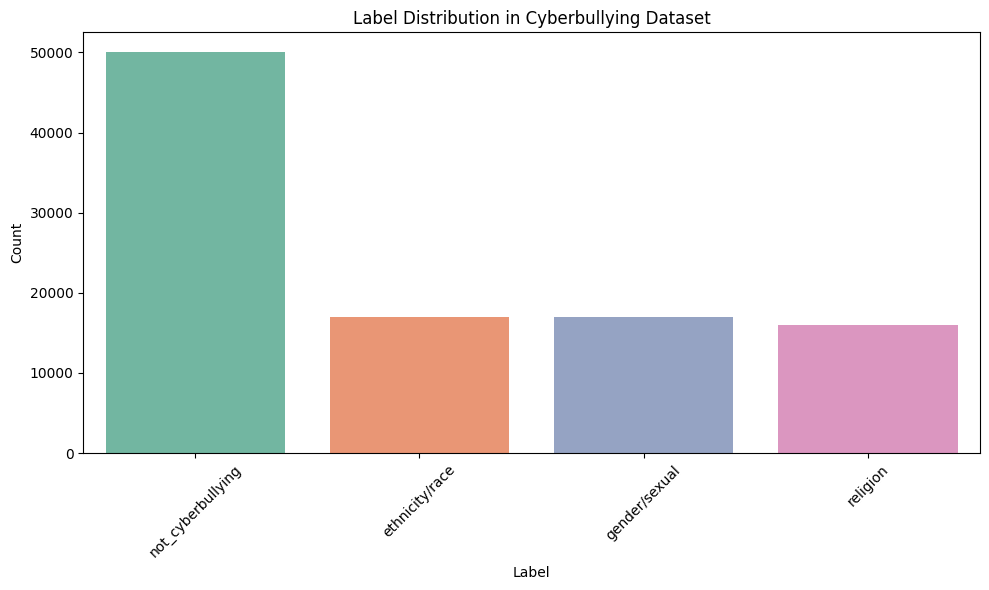

In [ ]:


# Plot label distribution using text labels
plt.figure(figsize=(10, 6))
sns.barplot(
    x=cb_df['label'].value_counts().index,
    y=cb_df['label'].value_counts().values,
    palette="Set2"
)
plt.xticks(rotation=45)
plt.title("Label Distribution in Cyberbullying Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply preprocessing
cb_df['text'] = cb_df['text'].apply(preprocess_text)

In [ ]:
# Mapping text labels to numeric labels (correct for training)
CB_LABELS = {"ethnicity/race": 0,
             "gender/sexual": 1,
             "religion": 2,
             "not_cyberbullying": 3
             }
cb_df["label"] = cb_df["label"].map(CB_LABELS)


In [ ]:
# Display processed data
cb_df.head()

,text,label
0,any real nigga isnt letting this happen,0
1,i didnt even mention mexico but the us is far ...,3
2,the only thing i wish i wish a nigga would,0
3,you saudias are not friends of muslim idiots c...,2
4,and yet the maga want to do just that the juda...,2


In [ ]:
### Tokenization and Data Preparation
from sklearn.model_selection import train_test_split

train_df, test_dev_df = train_test_split(cb_df, test_size=0.25, random_state=42)

dev_df = test_dev_df.sample(n=2000, random_state=42)
test_df = test_dev_df.drop(dev_df.index)

# Extract text and labels from DataFrames
train_texts, train_labels = train_df["text"].tolist(), train_df["label"].tolist()
dev_texts, dev_labels = dev_df["text"].tolist(), dev_df["label"].tolist()
test_texts, test_labels = test_df["text"].tolist(), test_df["label"].tolist()

# Print dataset sizes for confirmation
print(f"✅ Training set size: {len(train_texts)}")
print(f"✅ Development set size: {len(dev_texts)} (should be exactly 2000)")
print(f"✅ Test set size: {len(test_texts)}")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

cb_dataset = DatasetDict({
    "train": Dataset.from_dict({
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "label": train_labels
    }),
    "validation": Dataset.from_dict({
        "input_ids": dev_encodings["input_ids"],
        "attention_mask": dev_encodings["attention_mask"],
        "label": dev_labels
    }),
    "test": Dataset.from_dict({
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        "label": test_labels
    })
})

✅ Training set size: 74992
✅ Development set size: 2000 (should be exactly 2000)
✅ Test set size: 22998


In [ ]:
# Apply tokenization and filtering
for split in ["train", "validation"]:
    cb_dataset[split] = cb_dataset[split].filter(lambda example: len(example["input_ids"]) > 10)
    cb_dataset[split] = cb_dataset[split].shuffle()

cb_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

Filter:   0%|          | 0/74992 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Get minimum class count
min_count = train_df['label'].value_counts().min()

# Resample each class
balanced_train_dfs = [resample(train_df[train_df['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in train_df['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution
print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
0    12030
1    12030
2    12030
3    12030
Name: count, dtype: int64


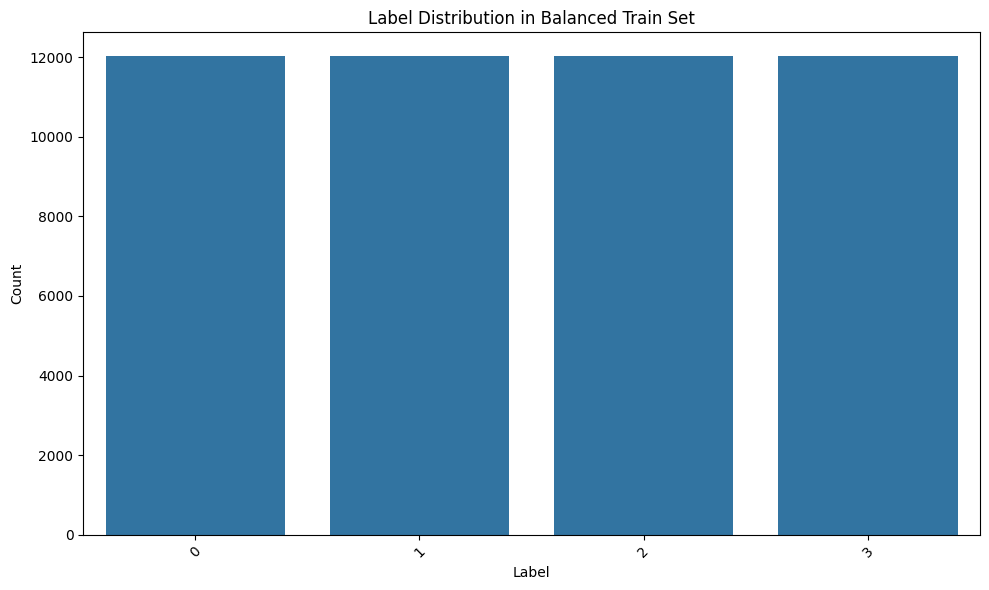

In [ ]:
# Plot balanced dataset label distribution -------
plt.figure(figsize=(10, 6))
sns.barplot(x=balanced_train_df['label'].value_counts().index,
            y=balanced_train_df['label'].value_counts().values)
plt.xticks(rotation=45)
plt.title("Label Distribution in Balanced Train Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Define prompts
cb_prompt = "Classify the given text into one of four categories:\n0. Ethnicity/Race - Cyberbullying related to ethnicity or race.\n1. Gender/Sexual - Cyberbullying based on gender or sexual identity.\n2. Religion - Cyberbullying related to religious beliefs or identity.\n3. Not Cyberbullying - The text does not contain cyberbullying content.\nText: "



In [ ]:
# Add prompt to text column
cb_df["text"] = cb_prompt + cb_df["text"]


In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        logits = output.preds_by_head["cyberbullying_classification_1"]

        if logits.dim() == 3:
            logits = logits[:, 0, :]

        loss = self.loss_fn(logits, labels) if labels is not None else None
        return SequenceClassifierOutput(loss=loss, logits=logits)

    def gradient_checkpointing_enable(self, *args, **kwargs):
        self.base_model.gradient_checkpointing_enable(*args, **kwargs)



In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(MODEL_NAME)
print(config.hidden_size)


2304


In [ ]:
in_size=config.hidden_size


## Step 5: Define Transformer Heads for Cyberbullying

In [ ]:
# Define model head and load base model

config = AutoConfig.from_pretrained(MODEL_NAME)

head_configs = [
    HeadConfig(
        name="cyberbullying_classification_1",
        in_size=config.hidden_size,
        num_outputs=4,
        layer_hook=-1,
        loss_fct="cross_entropy"
    )
]

base_model = load_headed(
    GemmaForSequenceClassification,
    MODEL_NAME,
    head_configs=head_configs,
    device_map=None,
    quantization_config=None,
)


base_model.gradient_checkpointing_enable()

# Wrap the model
model_cyberbullying = WrappedModel(base_model)


You are using a model of type gemma2 to instantiate a model of type gemma. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of TransformerWithHeads were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['heads.cyberbullying_classification_1.lins.0.weight', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(next(model_cyberbullying.parameters()).device)


cpu


## Step 6: Define Training Arguments and Trainer

In [ ]:
### Step 6: Define Training Arguments and Trainer
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    learning_rate = 5e-02,
    weight_decay = 0.0,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    adam_epsilon = 1e-08,
    max_grad_norm = 1.0,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    logging_dir="./logs",
    report_to="none",
    gradient_checkpointing=True,
    bf16=True,
    fp16=False,
)


/home/aishas/miniconda3/envs/aggression_py312/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step:8 Add the compute_metrics function

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }


Step:9 Train the model

In [ ]:
# Clear GPU memory before training
import torch
torch.cuda.empty_cache()

# Print Training Arguments before training starts
print("Training Arguments:", training_args)

# Initialize the Trainer
trainer = Trainer(
    model=model_cyberbullying,
    args=training_args,
    train_dataset=cb_dataset["train"],
    eval_dataset=cb_dataset["validation"],
    compute_metrics=compute_metrics,
)


# Start Training
trainer.train()


Training Arguments: TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=True,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalSt

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/aishas/miniconda3/envs/aggression_py312/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,15.634100,3.106369,0.765000,0.759087,0.761079,0.806124


TrainOutput(global_step=586, training_loss=15.63406903263652, metrics={'train_runtime': 594.6149, 'train_samples_per_second': 126.119, 'train_steps_per_second': 0.986, 'total_flos': 0.0, 'train_loss': 15.63406903263652, 'epoch': 1.0})


## Step 10: Evaluate on Test Set


📊 Test Set Metrics:
Accuracy:  0.8584
Precision: 0.8452
Recall:    0.8346
F1 Score:  0.8354

Detailed Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.81      0.81      0.81      3954
    gender/sexual       0.90      0.70      0.79      3849
not_cyberbullying       0.89      0.91      0.90     11543
         religion       0.78      0.92      0.84      3652

         accuracy                           0.86     22998
        macro avg       0.85      0.83      0.84     22998
     weighted avg       0.86      0.86      0.86     22998



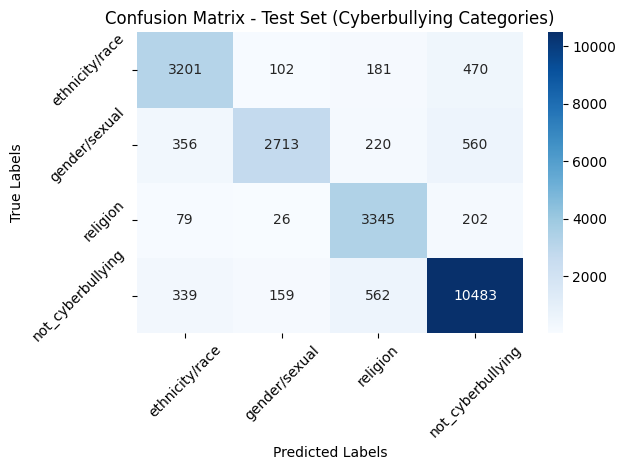

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reverse label map
INV_CB_LABELS = {v: k for k, v in CB_LABELS.items()}

# Run prediction on test set
predictions = trainer.predict(cb_dataset["test"])
logits = predictions[0]
predicted_labels = logits.argmax(axis=-1)

predicted_text_labels = [INV_CB_LABELS[label] for label in predicted_labels]
true_text_labels = [INV_CB_LABELS[label] for label in test_labels]

# Print individual metrics
print("\n📊 Test Set Metrics:")
print(f"Accuracy:  {accuracy_score(test_labels, predicted_labels):.4f}")
print(f"Precision: {precision_score(test_labels, predicted_labels, average='macro'):.4f}")
print(f"Recall:    {recall_score(test_labels, predicted_labels, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(test_labels, predicted_labels, average='macro'):.4f}")

# Detailed classification report with human-readable labels
print("\nDetailed Classification Report:")
print(classification_report(true_text_labels, predicted_text_labels))

# Confusion matrix with text labels
conf_matrix = confusion_matrix(true_text_labels, predicted_text_labels, labels=list(CB_LABELS.keys()))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=CB_LABELS.keys(), yticklabels=CB_LABELS.keys())

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set (Cyberbullying Categories)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
